In [ ]:
from matplotlib.pyplot import hist
import glob
import numpy as np
import skimage as ski
from matplotlib import pyplot as plt
import cv2
from skimage.feature import graycomatrix


check_paths = glob.glob("chceck/**/*.jp*g", recursive=True)
test_paths = glob.glob("test/**/*.jp*g", recursive=True)

# Combine the lists
image_paths = check_paths + test_paths

for path in image_paths:
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    distance = 1
    angle = 7 * np.pi/4

    glcm = graycomatrix(
        image, distances=[distance], angles=[angle], levels=256, symmetric=True, normed=True
    )
    glcm_vector = glcm[:, :, 0, 0].reshape(-1)
    fig, ax = plt.subplots(2, 3, figsize=(12, 6))

    image_lbp = ski.feature.local_binary_pattern(image, P=16, R=1, method="uniform")
    image_lbp = image_lbp.astype(np.uint8)
    lbp_hist, _ = np.histogram(image_lbp.ravel(), bins=np.arange(0, image_lbp.max() + 2), density=True)


    lbp_vector = lbp_hist.reshape(-1)  # (ή: lbp_vector = lbp_hist if already 1D)

    fd, hog_image = ski.feature.hog(
        image,
        orientations=9,
        pixels_per_cell=(8,8),
        cells_per_block=(3,3),
        visualize=True,
        feature_vector=False,
    )

    hog_vector = fd.reshape(-1)

    hog_image_rescaled = ski.exposure.rescale_intensity(
        hog_image, in_range=(0, 1), out_range=(0, 1)
    )

    print(f"\nΕικόνα: {path}")
    print(f"GLCM shape: {glcm[:, :, 0, 0].shape}, vector: {glcm_vector.shape}")
    print(f"LBP hist shape: {lbp_hist.shape}, vector: {lbp_vector.shape}")
    print(f"HOG shape: {fd.shape}, vector: {hog_vector.shape}")

    # print(f"Shape of descriptors: {fd.shape}")
    # print(f"Blocks: {fd.shape[0]}x{fd.shape[1]} = {fd.shape[0] * fd.shape[1]}")
    # for i in range(fd.shape[0]):
    #     for j in range(fd.shape[1]):
    #         print(f"Block ({i}, {j}):")
    #        print(fd[i, j])

    plt.subplot(2, 3, 1)
    plt.imshow(image, cmap="gray")

    plt.subplot(2, 3, 2)
    plt.imshow(image_lbp, cmap="gray")

    plt.subplot(2, 3, 3)
    plt.imshow(glcm[:, :, 0, 0], cmap="gray")

    plt.subplot(2, 3, 4)
    plt.hist(
        image_lbp.ravel(),
        bins=np.arange(0, image_lbp.max() + 2) - 0.5,
        density=True
    )
    plt.title("LBP Histogram")
    plt.xlabel("LBP value")
    plt.ylabel("Frequency")

    plt.subplot(2, 3, 5)
    plt.imshow(hog_image_rescaled, cmap="gray")
    plt.title("HOG")

    plt.show()

In [27]:
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import euclidean
import skimage

# Γ

prototype_images = {
    "cow": "chcek/cow/cow_1001.jpg",
    "horse": "chcek/horse/horse_1001.jpeg",
    "nilgai": "chcek/Nilgai/nilgai_1001.jpeg",
    "buffelo": "chcek/water buffelo/buffelo_1001.jpeg"
}

prototypes = {}

for label, path in prototype_images.items():

    FIXED_SIZE = (128, 128)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, FIXED_SIZE)

    # Υπολογισμός χαρακτηριστικών όπως πριν:
    glcm = graycomatrix(image, distances=[1], angles=[7*np.pi/4], levels=256, symmetric=True, normed=True)
    glcm_vec = glcm[:, :, 0, 0].reshape(-1)

    lbp = skimage.feature.local_binary_pattern(image, P=500, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, int(lbp.max() + 2)), density=True)
    lbp_vec = lbp_hist.reshape(-1)

    hog_fd, _ = skimage.feature.hog(
        image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3),
        visualize=True, feature_vector=False
    )
    hog_vec = hog_fd.reshape(-1)

    scaler = StandardScaler()
    glcm_vec = scaler.fit_transform(glcm_vec.reshape(-1, 1)).flatten()
    lbp_vec = scaler.fit_transform(lbp_vec.reshape(-1, 1)).flatten()
    hog_vec = scaler.fit_transform(hog_vec.reshape(-1, 1)).flatten()

    prototypes[label] = {
        "GLCM": glcm_vec,
        "LBP": lbp_vec,
        "HOG": hog_vec
    }

for path in image_paths:
    if any(proto in path for proto in prototype_images.values()):
        continue  # skip prototypes

    FIXED_SIZE = (128, 128)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, FIXED_SIZE)
    # Παράδειγμα: GLCM
    glcm = graycomatrix(image, distances=[1], angles=[7*np.pi/4], levels=256, symmetric=True, normed=True)
    glcm_vec = glcm[:, :, 0, 0].reshape(-1)

    lbp = skimage.feature.local_binary_pattern(image, P=500, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, int(lbp.max() + 2)), density=True)
    lbp_vec = lbp_hist.reshape(-1)

    hog_fd, _ = skimage.feature.hog(
        image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3),
        visualize=True, feature_vector=False
    )
    hog_vec = hog_fd.reshape(-1)

    scaler = StandardScaler()
    glcm_vec = scaler.fit_transform(glcm_vec.reshape(-1, 1)).flatten()
    lbp_vec = scaler.fit_transform(lbp_vec.reshape(-1, 1)).flatten()
    hog_vec = scaler.fit_transform(hog_vec.reshape(-1, 1)).flatten()

    similarities = {}
    for label, data in prototypes.items():
        dist1 = euclidean(glcm_vec, data["GLCM"])
        dist2 = euclidean(lbp_vec, data["LBP"])
        dist3 = euclidean(hog_vec, data["HOG"])
        dist_sum = dist1 + dist2 + dist3
        similarities[label] = dist_sum

    predicted_label = min(similarities, key=similarities.get)

    print(f"Image: {path}")
    print("Distances:", similarities)
    print("Predicted label based on GLCM:", predicted_label)

Image: test/cow/cow_0002.jpg
Distances: {'cow': 496.7607490126981, 'horse': 432.14264163346024, 'nilgai': 489.9119089539559, 'buffelo': 480.86560443972604}
Predicted label based on GLCM: horse
Image: test/cow/cow_0000.jpg
Distances: {'cow': 534.4627353396903, 'horse': 481.6556275113464, 'nilgai': 535.2303405008194, 'buffelo': 537.9286164499337}
Predicted label based on GLCM: horse
Image: test/cow/cow_0005.jpg
Distances: {'cow': 521.1282664239893, 'horse': 500.37675860811214, 'nilgai': 520.1237260855453, 'buffelo': 512.6332503880758}
Predicted label based on GLCM: horse
Image: test/cow/cow_0001.jpg
Distances: {'cow': 431.4648504584891, 'horse': 466.44089639770084, 'nilgai': 478.10514731363526, 'buffelo': 449.1616745491552}
Predicted label based on GLCM: cow
Image: test/cow/cow_0004.jpg
Distances: {'cow': 425.55682513643694, 'horse': 478.8486493175694, 'nilgai': 480.36261542857665, 'buffelo': 465.92983153555116}
Predicted label based on GLCM: cow
Image: test/cow/cow_0006.jpg
Distances: {

Predicted label: horse


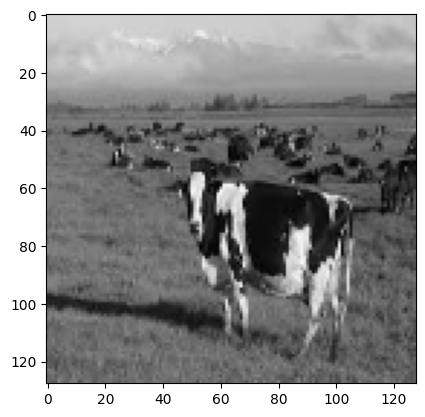

Predicted label: horse


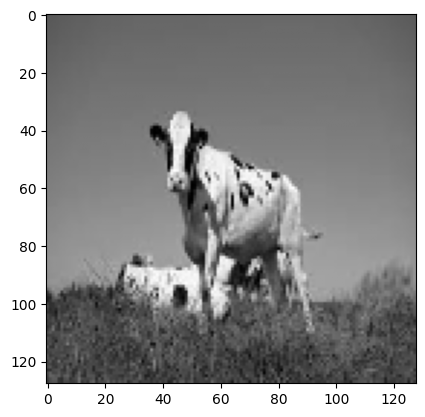

Predicted label: horse


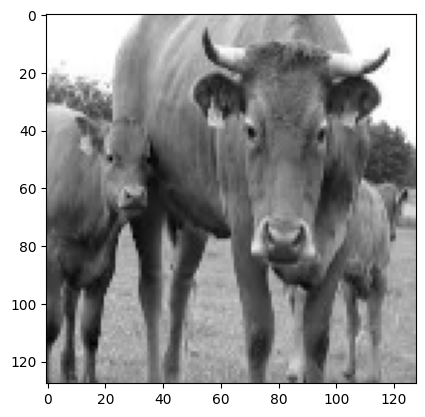

Predicted label: cow


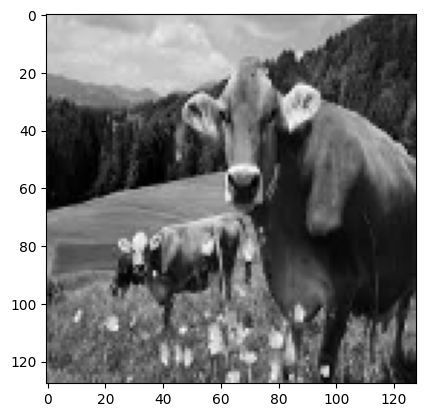

Predicted label: cow


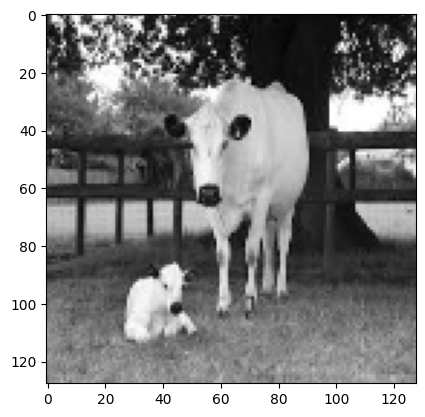

Predicted label: cow


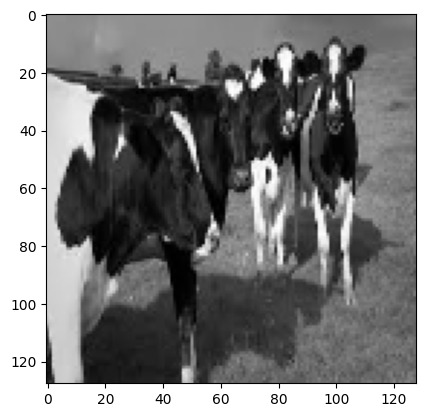

Predicted label: nilgai


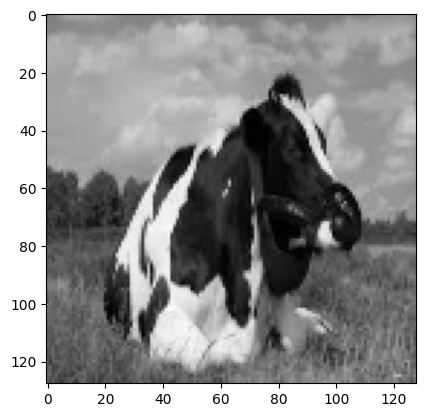

Predicted label: cow


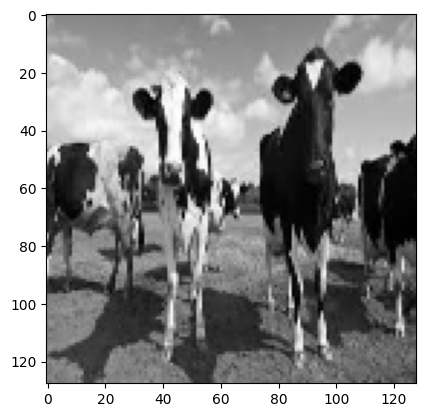

Predicted label: cow


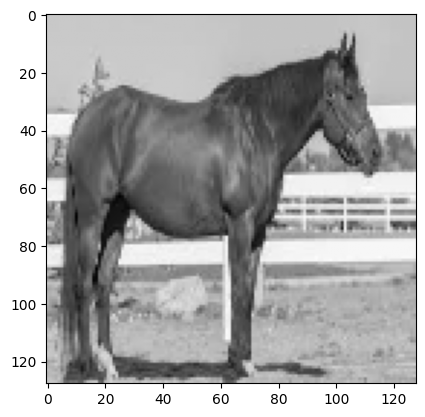

Predicted label: horse


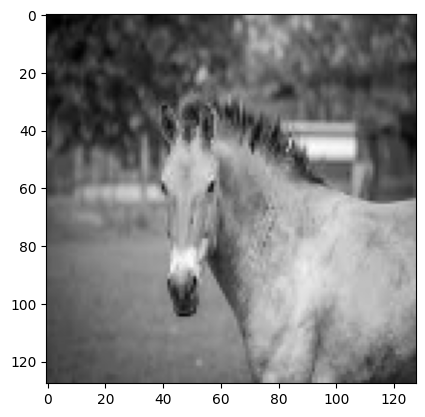

Predicted label: nilgai


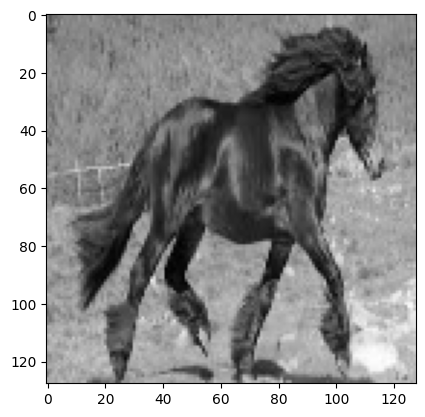

Predicted label: nilgai


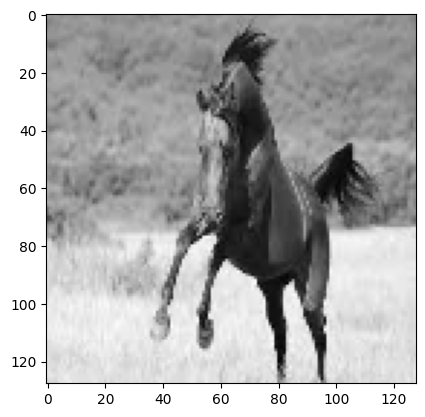

Predicted label: nilgai


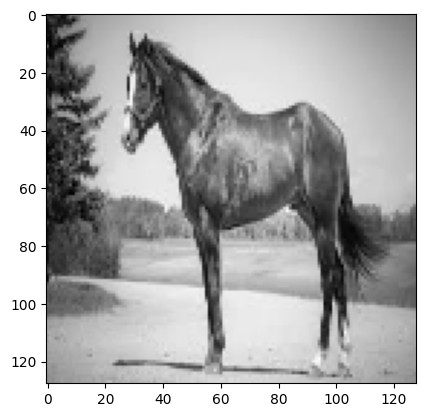

Predicted label: cow


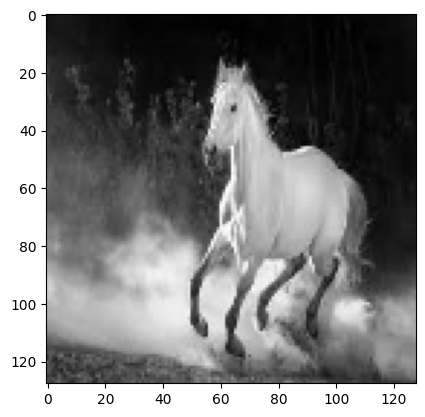

Predicted label: nilgai


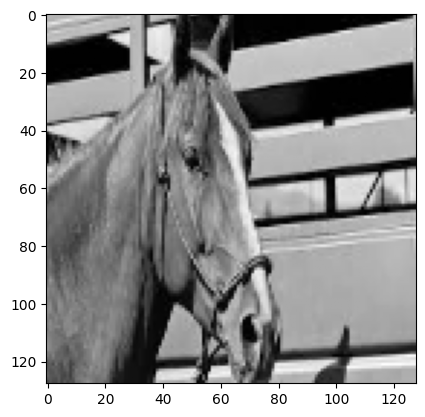

Predicted label: horse


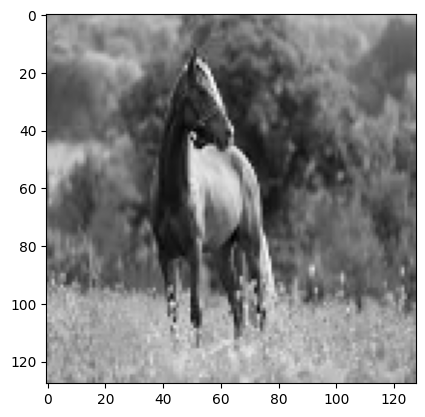

Predicted label: nilgai


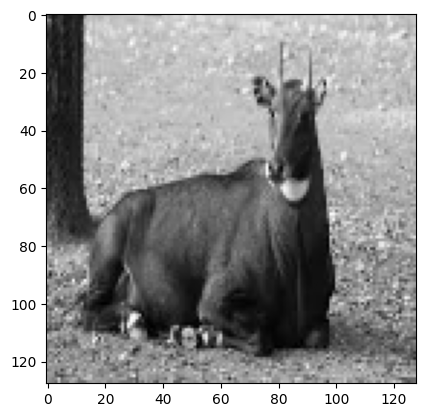

Predicted label: horse


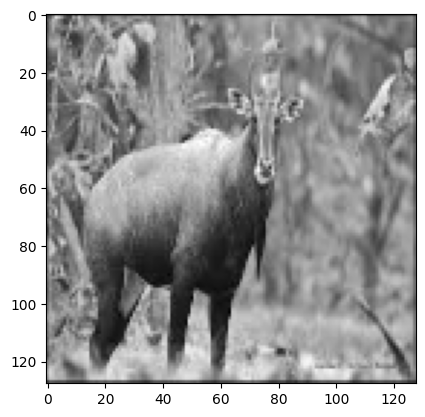

Predicted label: nilgai


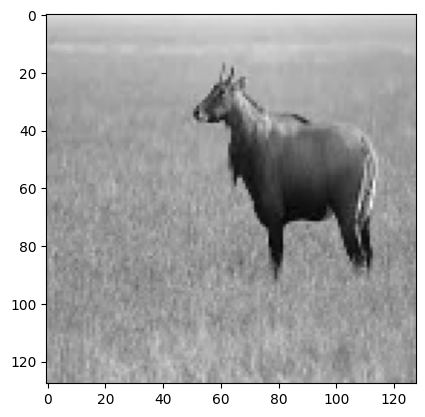

Predicted label: horse


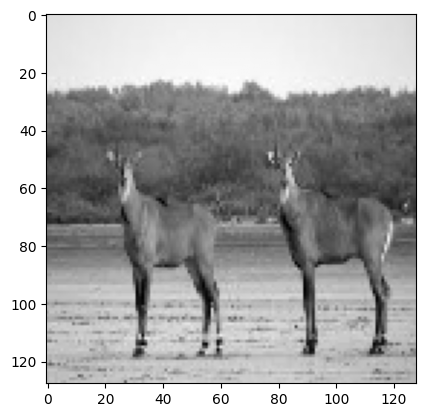

Predicted label: horse


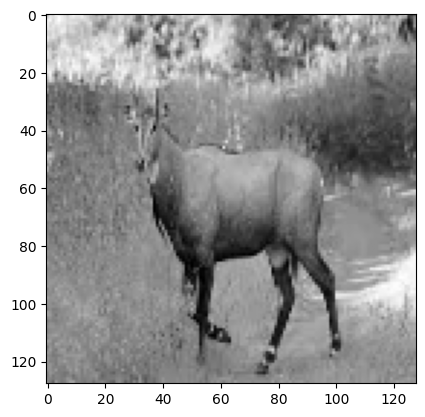

Predicted label: nilgai


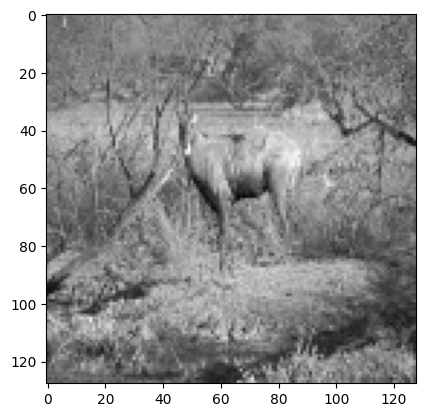

Predicted label: horse


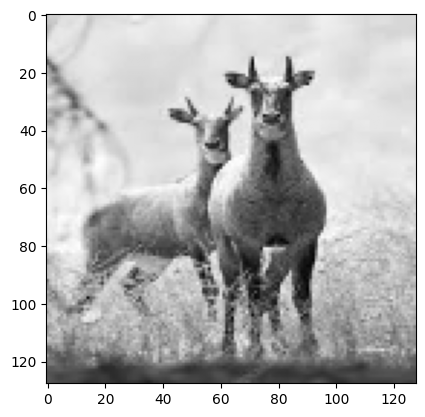

Predicted label: horse


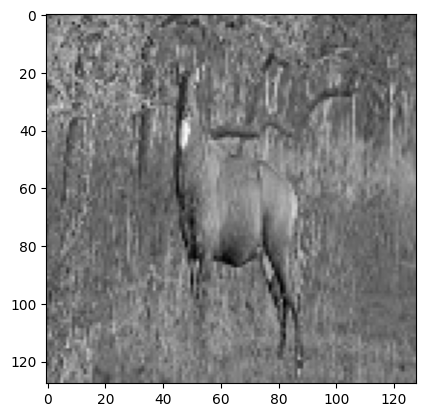

Predicted label: nilgai


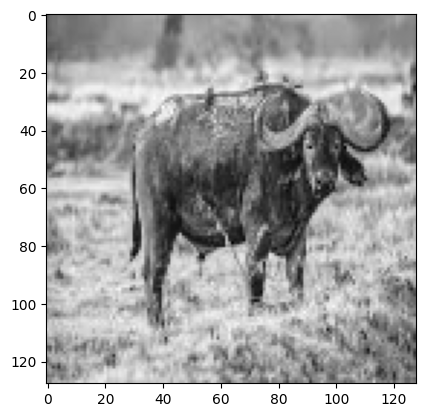

Predicted label: nilgai


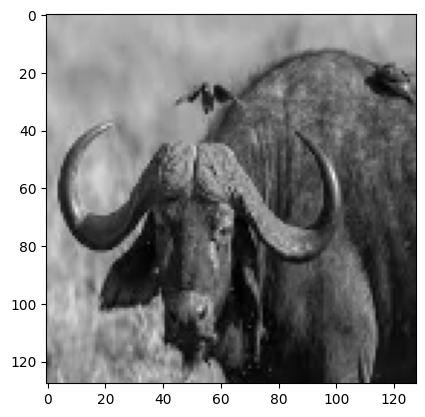

Predicted label: horse


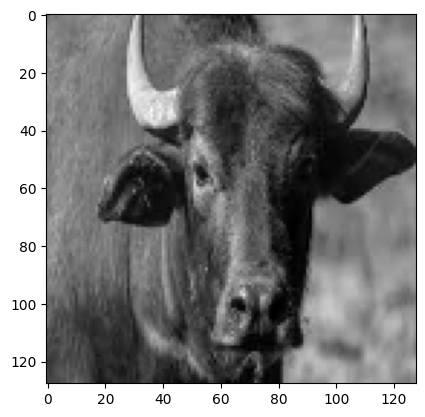

Predicted label: buffelo


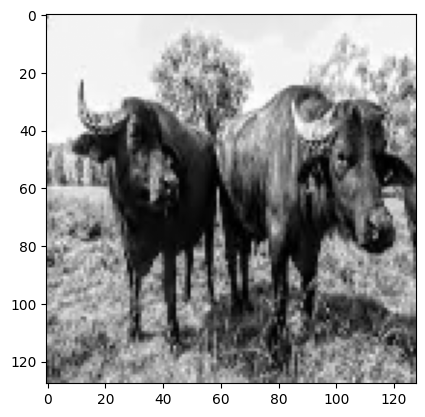

Predicted label: nilgai


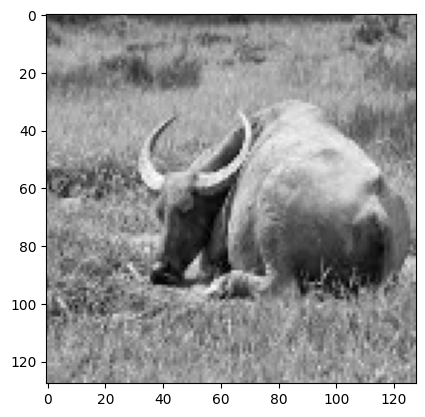

Predicted label: nilgai


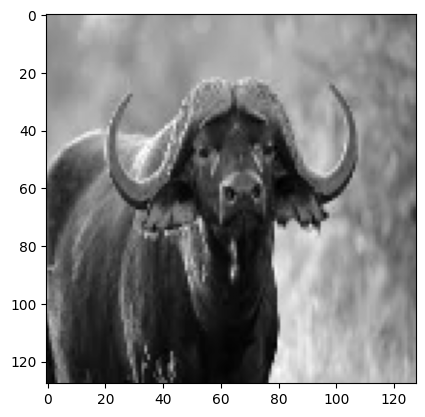

Predicted label: nilgai


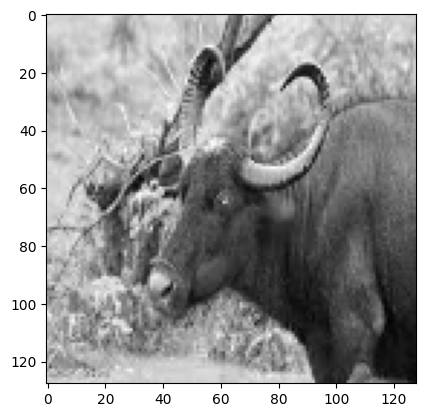

Predicted label: nilgai


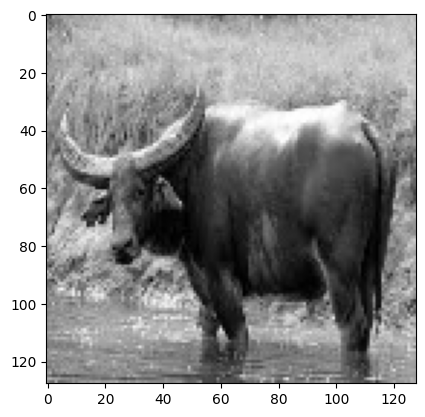

In [32]:
# Δ
for label, path in prototype_images.items():

    FIXED_SIZE = (128, 128)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, FIXED_SIZE)

    # Υπολογισμός χαρακτηριστικών όπως πριν:
    glcm = graycomatrix(image, distances=[1], angles=[7*np.pi/4], levels=256, symmetric=True, normed=True)
    glcm_vec = glcm[:, :, 0, 0].reshape(-1)

    lbp = skimage.feature.local_binary_pattern(image, P=500, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, int(lbp.max() + 2)), density=True)
    lbp_vec = lbp_hist.reshape(-1)

    hog_fd, _ = skimage.feature.hog(
        image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3),
        visualize=True, feature_vector=False
    )
    hog_vec = hog_fd.reshape(-1)

    scaler = StandardScaler()
    glcm_vec = scaler.fit_transform(glcm_vec.reshape(-1, 1)).flatten()
    lbp_vec = scaler.fit_transform(lbp_vec.reshape(-1, 1)).flatten()
    hog_vec = scaler.fit_transform(hog_vec.reshape(-1, 1)).flatten()

    prototypes[label] = {
        "GLCM": glcm_vec,
        "LBP": lbp_vec,
        "HOG": hog_vec
    }

for path in test_paths:
    if any(proto in path for proto in prototype_images.values()):
        continue  # skip prototypes

    FIXED_SIZE = (128, 128)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, FIXED_SIZE)
    # Παράδειγμα: GLCM
    glcm = graycomatrix(image, distances=[1], angles=[7*np.pi/4], levels=256, symmetric=True, normed=True)
    glcm_vec = glcm[:, :, 0, 0].reshape(-1)

    lbp = skimage.feature.local_binary_pattern(image, P=500, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, int(lbp.max() + 2)), density=True)
    lbp_vec = lbp_hist.reshape(-1)

    hog_fd, _ = skimage.feature.hog(
        image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3),
        visualize=True, feature_vector=False
    )
    hog_vec = hog_fd.reshape(-1)

    scaler = StandardScaler()
    glcm_vec = scaler.fit_transform(glcm_vec.reshape(-1, 1)).flatten()
    lbp_vec = scaler.fit_transform(lbp_vec.reshape(-1, 1)).flatten()
    hog_vec = scaler.fit_transform(hog_vec.reshape(-1, 1)).flatten()
    plt.imshow(image, cmap='gray')

    similarities = {}
    for label, data in prototypes.items():
        dist1 = euclidean(glcm_vec, data["GLCM"])
        dist2 = euclidean(lbp_vec, data["LBP"])
        dist3 = euclidean(hog_vec, data["HOG"])
        dist_sum = dist1 + dist2 + dist3
        similarities[label] = dist_sum

    predicted_label = min(similarities, key=similarities.get)

    print(f"Predicted label: {predicted_label}")

    plt.show()

In [29]:
import os
# E
from sklearn.metrics import accuracy_score


true_labels = []
predicted_labels_glcm = []
predicted_labels_lbp = []
predicted_labels_hog = []

for path in test_paths:
    if any(proto in path for proto in prototype_images.values()):
        continue  # skip prototypes

    FIXED_SIZE = (128, 128)
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, FIXED_SIZE)

    # GLCM
    glcm = graycomatrix(image, distances=[1], angles=[7*np.pi/4], levels=256, symmetric=True, normed=True)
    glcm_vec = glcm[:, :, 0, 0].reshape(-1)
    glcm_vec = StandardScaler().fit_transform(glcm_vec.reshape(-1, 1)).flatten()

    # LBP
    lbp = skimage.feature.local_binary_pattern(image, P=500, R=1, method='uniform')
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, int(lbp.max() + 2)), density=True)
    lbp_vec = lbp_hist.reshape(-1)
    lbp_vec = StandardScaler().fit_transform(lbp_vec.reshape(-1, 1)).flatten()

    # HOG
    hog_fd, _ = skimage.feature.hog(
        image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(3, 3),
        visualize=True, feature_vector=False
    )
    hog_vec = hog_fd.reshape(-1)
    hog_vec = StandardScaler().fit_transform(hog_vec.reshape(-1, 1)).flatten()

    # Υπολογισμός αποστάσεων για κάθε χαρακτηριστικό
    similarities_glcm = {}
    similarities_lbp = {}
    similarities_hog = {}

    for label, data in prototypes.items():
        similarities_glcm[label] = euclidean(glcm_vec, data["GLCM"])
        similarities_lbp[label] = euclidean(lbp_vec, data["LBP"])
        similarities_hog[label] = euclidean(hog_vec, data["HOG"])

    predicted_glcm = min(similarities_glcm, key=similarities_glcm.get)
    predicted_lbp = min(similarities_lbp, key=similarities_lbp.get)
    predicted_hog = min(similarities_hog, key=similarities_hog.get)

    # ΠΡΑΓΜΑΤΙΚΗ ΕΤΙΚΕΤΑ ΑΠΟ ΤΟ PATH
    true_label = os.path.basename(os.path.dirname(path)).lower()
    true_labels.append(true_label)

    predicted_labels_glcm.append(predicted_glcm)
    predicted_labels_lbp.append(predicted_lbp)
    predicted_labels_hog.append(predicted_hog)

    print(f"\nImage: {path}")
    print("GLCM Distances:", similarities_glcm)
    print("LBP  Distances:", similarities_lbp)
    print("HOG  Distances:", similarities_hog)
    print("Predicted GLCM label:", predicted_glcm)
    print("Predicted LBP label:", predicted_lbp)
    print("Predicted HOG label:", predicted_hog)

# ΥΠΟΛΟΓΙΣΜΟΣ ACCURACY ΜΕΤΑ ΤΟ LOOP
acc_glcm = accuracy_score(true_labels, predicted_labels_glcm)
acc_lbp = accuracy_score(true_labels, predicted_labels_lbp)
acc_hog = accuracy_score(true_labels, predicted_labels_hog)

print("\n--- Accuracy Results ---")
print(f"GLCM Accuracy: {acc_glcm:.2%}")
print(f"LBP  Accuracy: {acc_lbp:.2%}")
print(f"HOG  Accuracy: {acc_hog:.2%}")




Image: test/cow/cow_0002.jpg
GLCM Distances: {'cow': 313.31226962593837, 'horse': 241.30123756293304, 'nilgai': 302.56904571221804, 'buffelo': 295.53050555689043}
LBP  Distances: {'cow': 2.118834882320348, 'horse': 3.3584366688143694, 'nilgai': 5.069165398359524, 'buffelo': 4.896080677239702}
HOG  Distances: {'cow': 181.3296445044394, 'horse': 187.48296740171287, 'nilgai': 182.27369784337833, 'buffelo': 180.43901820559591}
Predicted GLCM label: horse
Predicted LBP label: cow
Predicted HOG label: buffelo

Image: test/cow/cow_0000.jpg
GLCM Distances: {'cow': 342.3374012340168, 'horse': 283.67859433042617, 'nilgai': 336.41227972179456, 'buffelo': 337.68496758617306}
LBP  Distances: {'cow': 17.365914899278742, 'horse': 17.183975106368514, 'nilgai': 20.064726315467578, 'buffelo': 20.109180720216415}
HOG  Distances: {'cow': 174.75941920639482, 'horse': 180.7930580745517, 'nilgai': 178.75333446355725, 'buffelo': 180.13446814354413}
Predicted GLCM label: horse
Predicted LBP label: horse
Predi

In [30]:
# ΣΤ